# Анализ поведения клиентов сети фитнес-центров и подготовка плана действий по их удержанию

**Краткое описание проекта**

Сеть фитнес-центров ***разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.*** Для борьбы с оттоком, отдел по работе с клиентами перевёл в электронный вид множество клиентских анкет.

**Постановка задачи**

Необходимо ***провести анализ и подготовить план действий по удержанию клиентов.***
А именно:
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:

  1) выделить целевые группы клиентов;
  
  2) предложить меры по снижению оттока;
  
  3) определить другие особенности взаимодействия с клиентами.

## Изучение и предобработка данных

### Изучение данных

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

In [6]:
sns.set_palette('Set2')
sns.set_style('dark')
pd.set_option('display.float_format', '{:.2f}'.format)

In [7]:
df = pd.read_csv('datasets/gym_churn.csv')

In [8]:
def hello(df):
    df.columns = df.columns.str.lower()
    display(df.info())
    display(df.shape)
    display('Пропуски: ', df.isna().sum())
    display('Явные дубликаты: ', df.duplicated().sum())
    display('Количество столбцов с разными типами данных: ', df.dtypes.value_counts())
    display(df.head())

In [9]:
def hello(df):
    
    df.columns = df.columns.str.lower()
    
    drops = pd.DataFrame(
    {'кол-во пропусков': df.isna().sum(),
    '% пропусков': round((df.isna().sum() / len(df.index) *100))}
    )
    
    duplicates = pd.Series(
    {'кол-во дубликатов': df.duplicated().sum(),
    '% дубликатов': round(df.duplicated().sum() / len(df) * 100)}
    )
    
    print('Общая информация:')
    print()
    print(df.info())
    print('_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _')
    print('Пропуски:')
    display(drops)
    print('_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _')
    print('Явные дубликаты:')
    display(duplicates)
    print('_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _')
    display('Количество столбцов с разными типами данных:'),
    display(df.dtypes.value_counts())
    print('_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _')
    print('Шапка таблицы:')
    display(df.head())

In [10]:
hello(df)

Общая информация:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          40

,кол-во пропусков,% пропусков
gender,0,0.00
near_location,0,0.00
partner,0,0.00
promo_friends,0,0.00
phone,0,0.00
contract_period,0,0.00
group_visits,0,0.00
age,0,0.00
avg_additional_charges_total,0,0.00
month_to_end_contract,0,0.00


_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
Явные дубликаты:


кол-во дубликатов    0
% дубликатов         0
dtype: int64

_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _


'Количество столбцов с разными типами данных:'

int64      10
float64     4
dtype: int64

_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
Шапка таблицы:


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0


#### Предварительный вывод:
- Пропусков и дубликатов не обнаружено
- Названия столбцов приведены к змеиному регистру
- Большинство данных (10 столбцов из 14) имеют целочисленный тип, часть из них категориальные (нужно проверить на неявные дубликаты)
- Cтолбцы с вещественными числами отображаются до 2 знаков после запятой, столбец month_to_end_contract нужно привести к целочисленному типу

### Предобработка данных

In [13]:
# укоротим названия самых длинных столбцов для удобства

df = df.rename(columns={
                        'avg_additional_charges_total': 'avg_add_charges_tot',
                        'avg_class_frequency_total': 'avg_freq_tot',
                        'avg_class_frequency_current_month': 'avg_freq_cur_month'
                        }
                        )                        

In [14]:
# переместим столбцы в df местами так, чтобы все категориальные признаки шли друг за другом

df = df[[df.columns[i] for i in list(range(0, 5)) + [6] + [5] + list(range(7, 14))]]

In [15]:
# создадим список столбцов с категориальными признаками

category_columns = df.columns[0:6]

In [16]:
# создадим список столбцов с количественными признаками (пригодится далее)

quantitative_columns = df.columns[6:13]

In [17]:
# проверим все столбцы с категориальными данными (включая переменную) на наличие неявных дубликатов

#print('churn', df['churn'].unique())

for col in category_columns:
    print(col, df[col].unique())

gender [1 0]
near_location [1 0]
partner [1 0]
promo_friends [1 0]
phone [0 1]
group_visits [1 0]


In [18]:
# для удобства приведем данные столбца о сроке до окончания абонемента к типу int

df['month_to_end_contract'] = df['month_to_end_contract'].astype('int64')

#### Предварительный вывод:
- Неявных дубликатов в столбцах с категориальными данными не выявлено
- Столбец month_to_end_contract приведен к целочисленному типу 

### Вывод:
- Данные представлены 4000 записей и 14 столбцами: ***столбец churn - целевая переменная, остальные столбцы - признаки***
- Пропусков и дубликатов не обнаружено
- Названия столбцов приведены к змеиному регистру
- Большинство данных (10 столбцов из 14) имеют целочисленный тип, часть из них категориальные (7)
- Cтолбцы с вещественными числами отображаются до 2 знаков после запятой; данные столбца month_to_end_contract приведены к целочисленному типу

## Исследовательский анализ данных

### Общая оценка статистических показателей признаков

In [23]:
# выведем основные статданные по всем столбцам

df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.00,0.51,0.50,0.00,0.00,1.00,1.00,1.00
near_location,4000.00,0.85,0.36,0.00,1.00,1.00,1.00,1.00
partner,4000.00,0.49,0.50,0.00,0.00,0.00,1.00,1.00
promo_friends,4000.00,0.31,0.46,0.00,0.00,0.00,1.00,1.00
phone,4000.00,0.90,0.30,0.00,1.00,1.00,1.00,1.00
group_visits,4000.00,0.41,0.49,0.00,0.00,0.00,1.00,1.00
contract_period,4000.00,4.68,4.55,1.00,1.00,1.00,6.00,12.00
age,4000.00,29.18,3.26,18.00,27.00,29.00,31.00,41.00
avg_add_charges_tot,4000.00,146.94,96.36,0.15,68.87,136.22,210.95,552.59
month_to_end_contract,4000.00,4.32,4.19,1.00,1.00,1.00,6.00,12.00


#### Предварительный вывод:
- клиенты фитнес-центра примерно поровну делятся по половому признаку
- порядка 85% клиентов живут рядом с клубом
- порядка половины и трети клиентов приходят через компании-партнеры и по акции "приведи друга" соответственно
- 90% клиентов предоставляют данные о своем телефоне
- средний возраст клиента около 29 лет
- средний срок абонемента составляет почти 5 месяцев
- средний срок с момента первого обращения в фитнес-центр - менее 4 месяцев, а срок до окончания текущего абонемента - более 4 месяцев
- средняя посещаемость клуба - чуть менее 2-х раз в неделю, как за последний месяц, так и за весь срок действия абонемента
- груповые занятия посещают чуть больше 40% клиентов
- средний показатель оттока на уровне 27%

### Оценка средних значений признаков

In [26]:
df.groupby(by='churn').mean().T

churn,0,1
gender,0.51,0.51
near_location,0.87,0.77
partner,0.53,0.36
promo_friends,0.35,0.18
phone,0.90,0.90
group_visits,0.46,0.27
contract_period,5.75,1.73
age,29.98,26.99
avg_add_charges_tot,158.45,115.08
month_to_end_contract,5.28,1.66


#### Предварительный вывод:

Исходя из средних значений признаков **ушедшие клиенты по сравнению с оставшимися:**
- не отличаются по полу (примерно 50%/50%) и также часто оставляют свой номер телефона (90%)
- живут не в районе нахождения фитнес-центра - на 10% больше, чем среди оставшихся
- реже приходят по акции «приведи друга» (в 2 раза реже) или из компании-партнёра клуба (на 17% реже)
- в среднем на 3 года моложе (27 лет против 30 лет среди оставшихся)
- чаще выбирают более короткие абонементы: около 2 месяцев против 6 месяцев у оставшихся
- реже посещают фитнес-клуб (1 и 1,5 раза в неделю за последний месяц и за весь срок абонемента соответственно против 2 раз по обеим периодам у оставшихся)
- почти на 20% реже посещают групповые занятия
- уходят примерно через месяц после начала посещения фитнес-центра (у оставшихся клиентов срок с первого посещения клуба составляет на этот момент примерно 5 месяцев)
- соотвественно, меньше тратят денег на допуслуги в фитнес-центре за весь период: примерно на 30% меньше оставшихся

### Анализ столбчатых гистограмм и распределения признаков 

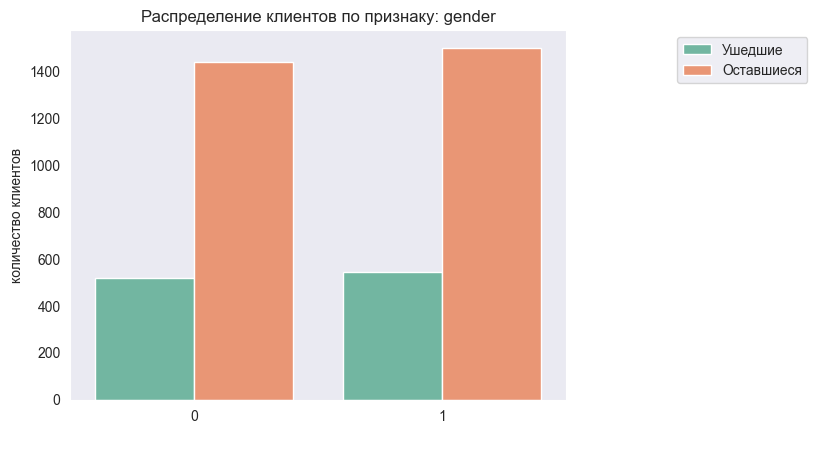

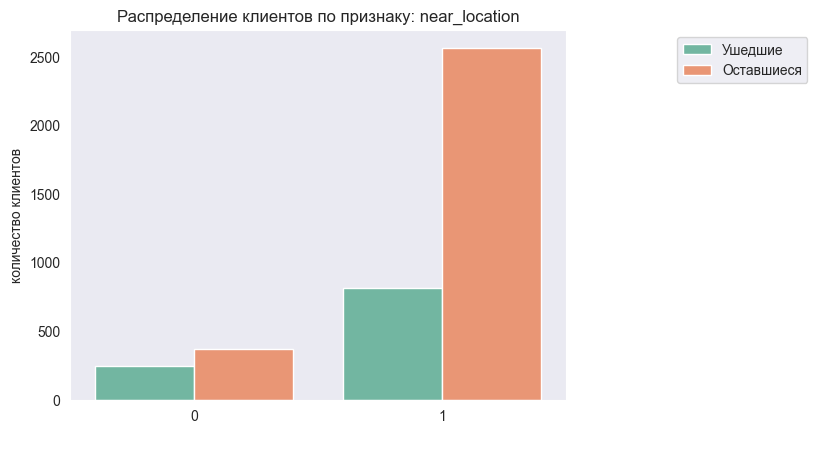

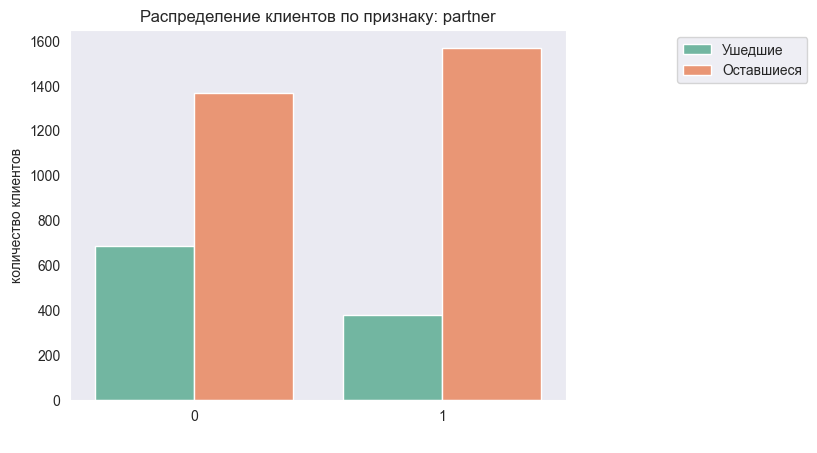

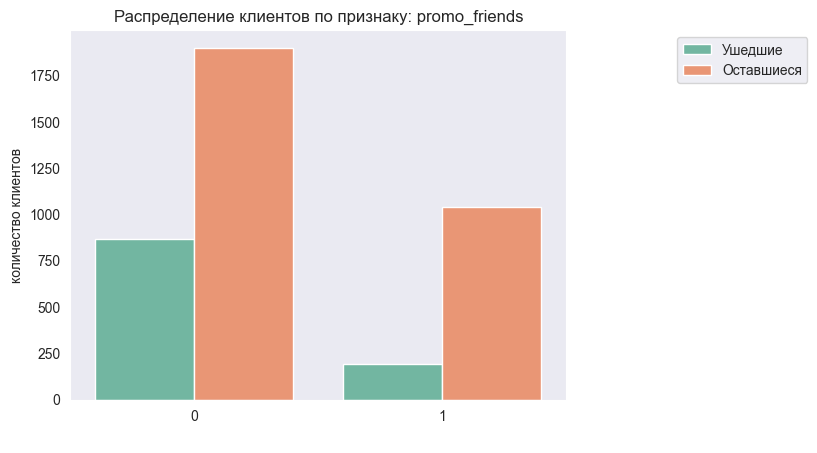

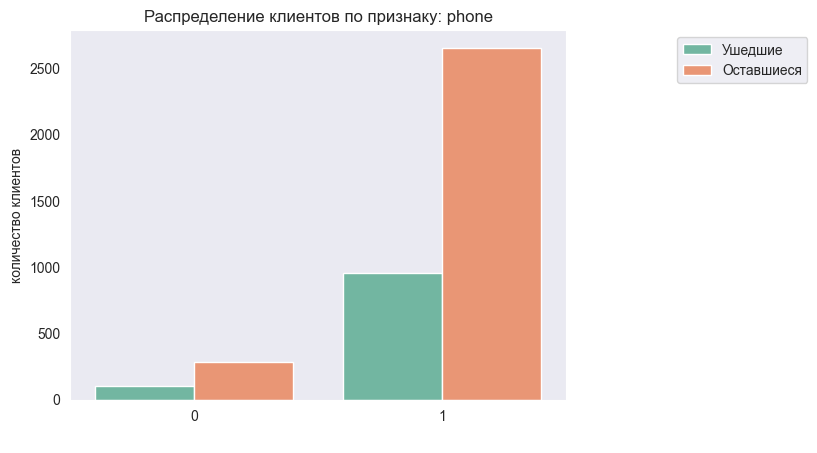

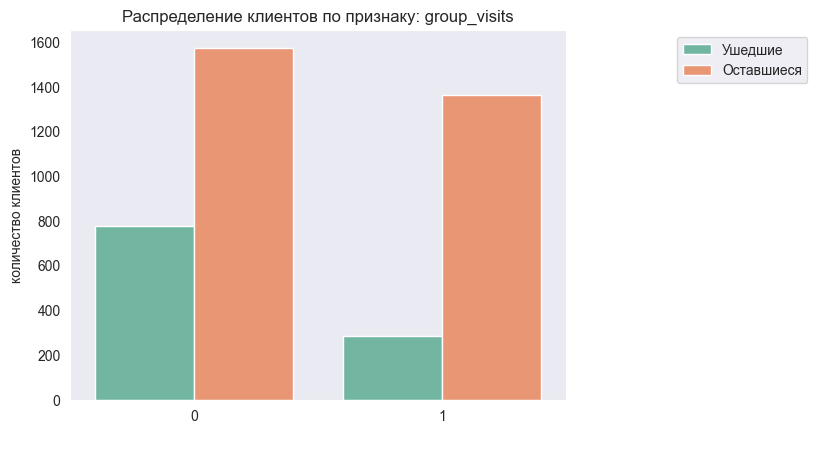

In [29]:
# построим countplot-графики для категориальных признаков

for col in category_columns:
    hue_order = [1, 0]
    sns.countplot(data=df, x=col, hue='churn', hue_order = hue_order)
    plt.title('Распределение клиентов по признаку: ' + col)
    plt.xlabel(' ')
    plt.ylabel('количество клиентов')
    plt.legend(['Ушедшие', 'Оставшиеся'], bbox_to_anchor=(1.5, 1))
    plt.show()

In [30]:
# до вывода графиков по количественным признакам, напишем фукнцию для вывода корректных подписей оси x

def xlabel_name(col):
    if col in ('contract_period', 'month_to_end_contract', 'lifetime'):
        return 'количество месяцев'
    if col in ('avg_freq_tot', 'avg_freq_cur_month'):
        return 'количество посещений в неделю'
    if col == 'age':
        return 'количество лет'
    else:
        return 'выручка'

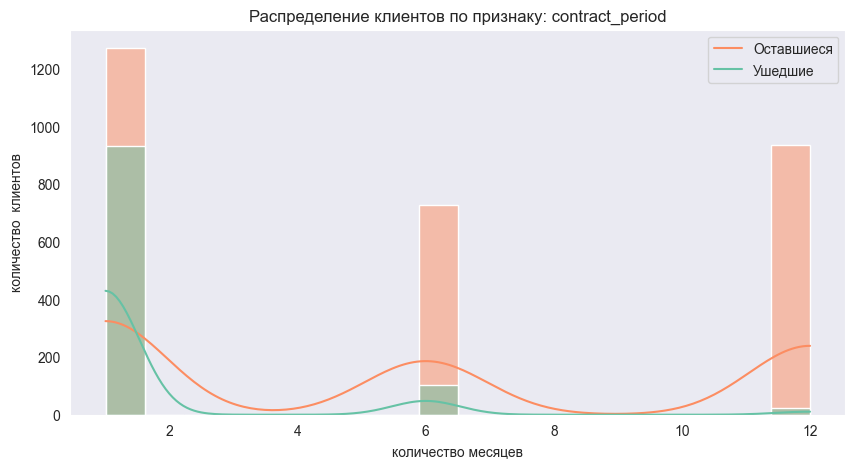

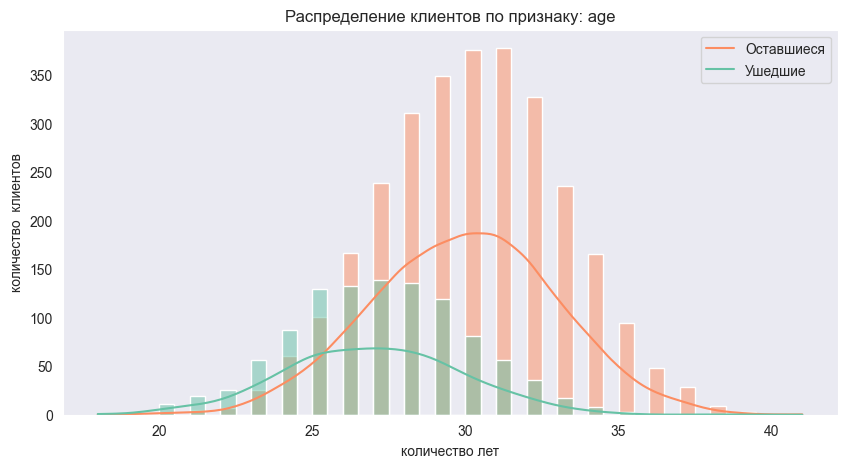

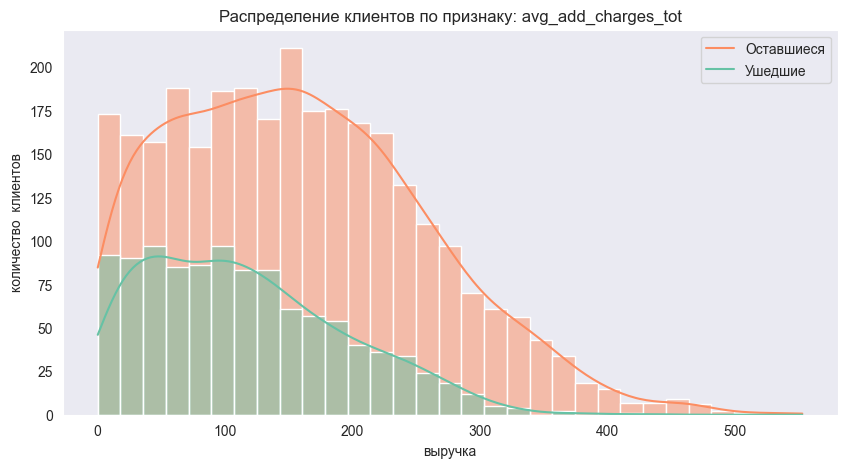

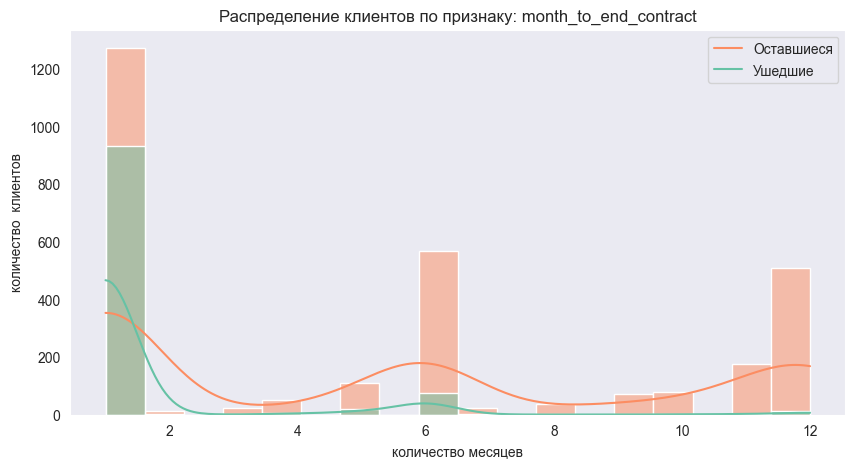

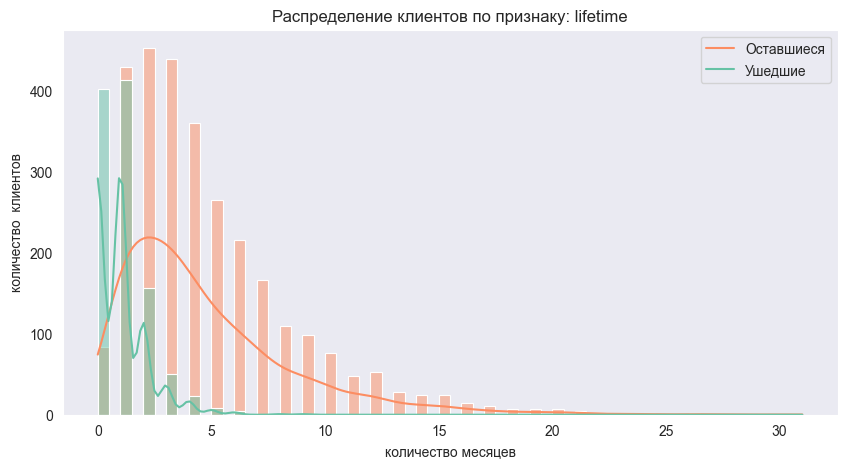

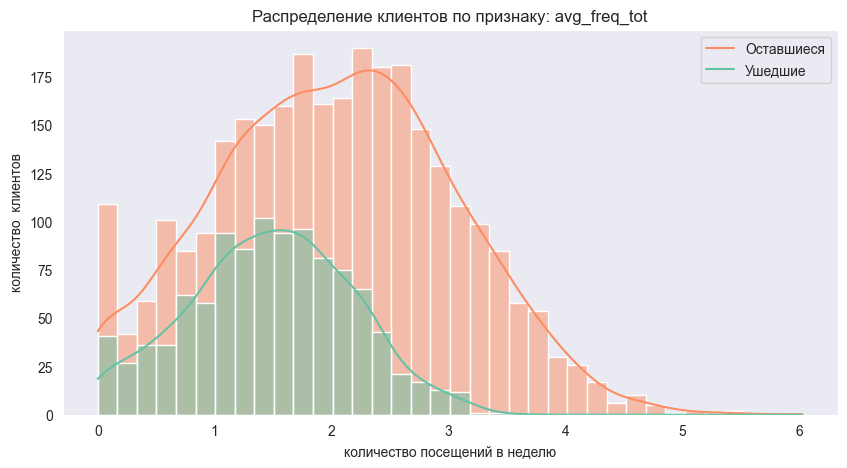

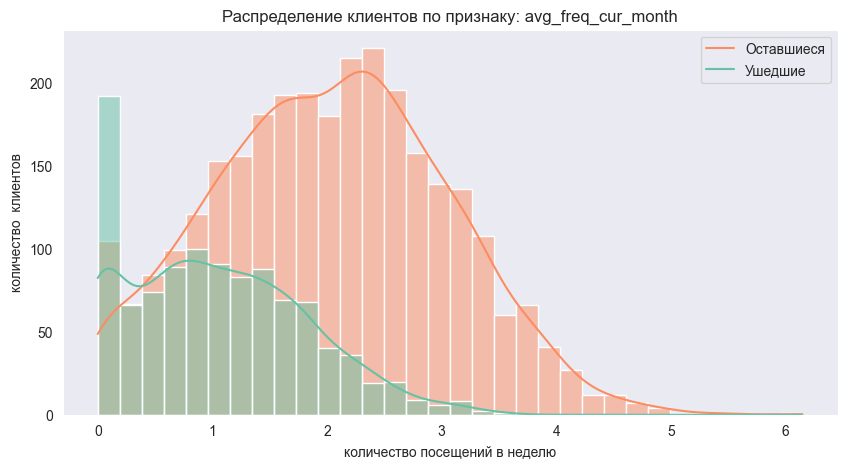

In [31]:
# построим гистограммы для количественных признаков

for col in quantitative_columns:
    plt.figure(figsize=(10, 5))
    hue_order = [1, 0]
    sns.histplot(data=df, x=col, hue='churn', kde=True, hue_order = hue_order)
    plt.legend(['Оставшиеся', 'Ушедшие'])
    plt.title('Распределение клиентов по признаку: ' + col)
    plt.xlabel(xlabel_name(col))
    plt.ylabel('количество  клиентов')
    plt.show()

- График классического нормального распределения наблюдается только по признаку: возраст клиентов
- По посещаемости, допрасходам и сроку посещения клуба - распределение скошено вправо
- Видны значения, похожие на выбросы, в районе 0 по графикам по количеству посещений фитнес-центра в неделю за последний месяц и за весь срок; изучим их более прицельно

- Странно, что за последний месяц локальный пик в районе 0 наблюдается по ушедшим клиентам, а за весь срок - преимущественно по оставшися клиентам
- Посмотрим, с помощью np.percentile как эти потенциальные выбросы выражены в процентном отношении ко всем записям

In [34]:
# считаем 1-й и 5-й перцентили по количеству посещений за весь срок среди всех клиентов

np.percentile(df['avg_freq_tot'], [1, 5])

array([0.        , 0.28520097])

In [35]:
# считаем 1-й и 5-й перцентили по количеству посещений за весь срок среди оставшихся клиентов

np.percentile(df[df['churn'] == 0]['avg_freq_tot'], [1, 5])

array([0.        , 0.30647944])

In [36]:
# считаем 1-й и 5-й перцентили по количеству посещений за последний месяц среди всех клиентов

np.percentile(df['avg_freq_cur_month'], [1, 5])

array([0.        , 0.03215052])

In [37]:
# считаем 1-й и 5-й перцентили по количеству посещений за последний месяц среди ушедших клиентов

np.percentile(df[df['churn'] == 1]['avg_freq_cur_month'], [1, 5])

array([0., 0.])

In [38]:
print(
      '% записей с нулевыми посещениями клуба в неделю за последний месяц, среди ушедших клиентов: ',
       round(len(df[(df['churn'] == 1) & (df['avg_freq_cur_month'] == 0)]) / len(df[df['churn'] == 1]) * 100)
)

% записей с нулевыми посещениями клуба в неделю за последний месяц, среди ушедших клиентов:  13


- 13% - это слишком много для того, чтобы можно было скорректировать эту аномалию
- к тому же с учетом того, что за весь период подобная "аномалия" наблюдатся, наоборот, среди оставшихся клиентов, то, вероятно, нельзя сделать вывод о том, что эти значения вообще можно отнести к выбросам

#### Предварительный вывод:
***Графики визуально подтверждают выводы, сделанные в п. 2.2 по оценке средних значений признаков:***
- по категориальным признакам: пол (примерно 50% на 50% для обеих групп клиентов), телефон (оставляют почти все клиенты из обеих групп), ушедшие клиенты реже приходят по акциям и от партнеров, реже посещают групповые занятия, живут несколько дальше
- по количественным признакам: у ушедших клиентов меньший возраст, меньший срок пользования клубом, меньшая посещаемость и меньшие допрасходы в фитнес-центре

### Построение матрицы корреляций

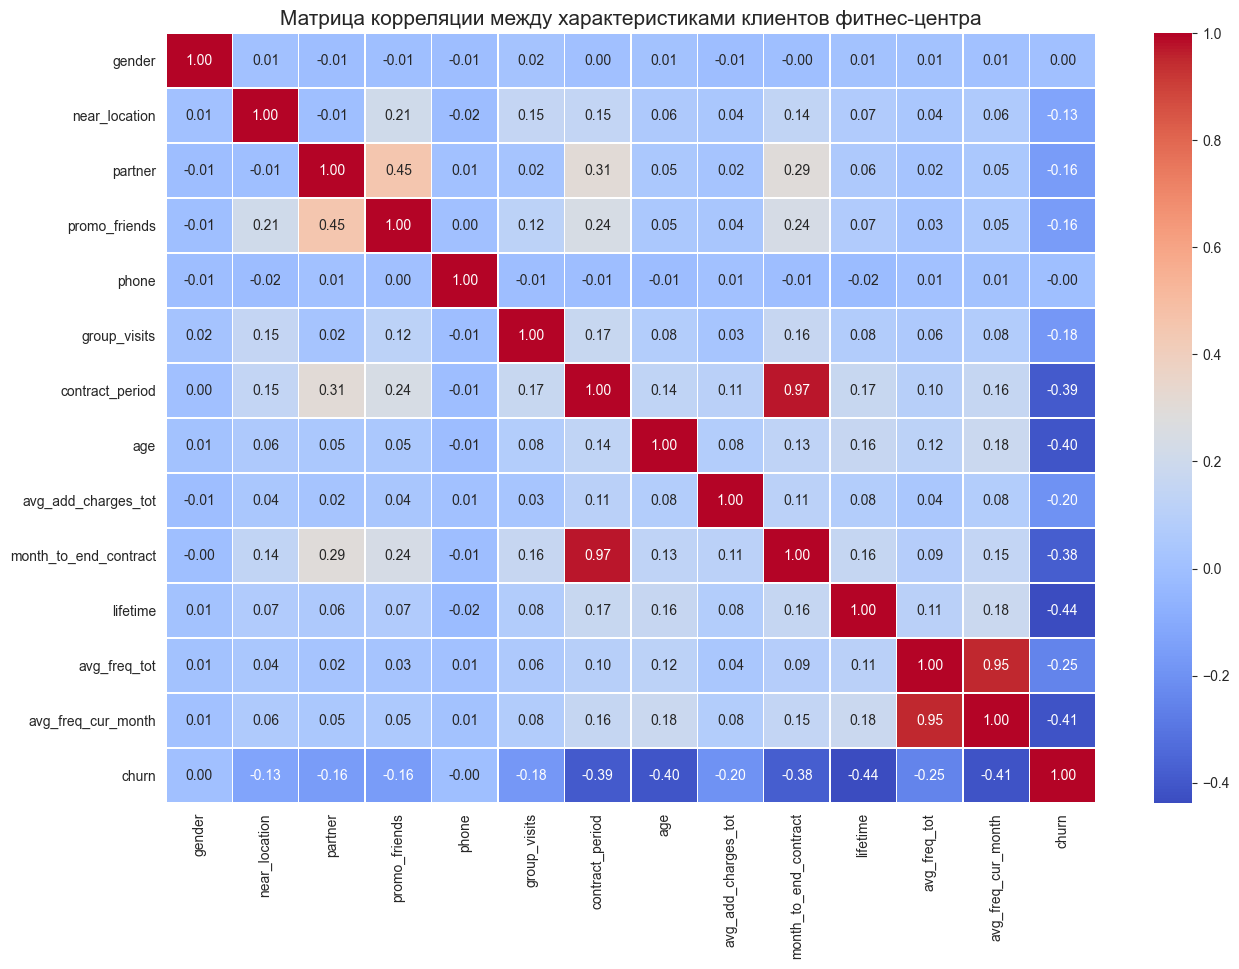

In [42]:
# построим матрицу коррелляции с помошью heatmap

cm = df.corr()
fig, ax = plt.subplots(figsize = (15, 10))
sns.heatmap(cm, annot=True, cmap='coolwarm',fmt='.2f', linewidths=.3)
plt.title('Матрица корреляции между характеристиками клиентов фитнес-центра', fontsize=15)
plt.show()

#### Предварительный вывод:
1) Видно, что есть ***2 пары столбцов с высокой мультиколлинераностью:***
- month_to_end_contract и contract_period
- avg_freq_tot и avg_freq_cur_month

2) Поскольку коэффициент корреляции чуть меньше 1, то при построении модели логистической регрессии ***нужно оценить необходимость удаления по 1 признаку из каждой пары мультиколлинеарных признаков***

2) Наблюдается небольшая обратная корреляция (до -0,45) между целевой переменной и рядом признаков:
- contract_period (-0,39)
- age (-0,4)
- month_to_end_contract (-0,38)
- lifetime (-0,44)
- avg_freq_cur_month (-0,41)

### Вывод:
1) ***Усредненный клиент фитнес-центра имеет следующие характеристики:***
- пол: либо мужчина, либо женщина в соотношении примерно 50%/50%
- средний возраст: ***29 лет***
- адрес: ***в 85% случаев живет рядом***
- телефон: в 90% случаев оставляет свой номер
- промо-акции: в 40% и 30% случаев приходит через компании-партнеры и по акции "приведи друга" соответственно
- средний срок абонемента: почти 5 месяцев
- средний срок с момента первого обращения в фитнес-центр - менее 4 месяцев
- средний срок до окончания текущего абонемента - более 4 месяцев
- средняя посещаемость клуба - около 2-х раз в неделю
- груповые занятия: посещает в среднем в 40% случаев
- средний отток: ***уходит из клуба насовсем в 27% случаев***

2) ***Клиенты, ушедшие из фитнес-центра, по сравнению с оставшимися характеризуются следующим образом:***
- живущих не в районе нахождения фитнес-центра - на 10% больше, чем среди оставшихся
- реже приходят по акции «приведи друга» (в 2 раза реже) или из компании-партнёра клуба (на 17% реже)
- ***в среднем на 3 года моложе*** (27 лет против 30 лет среди оставшихся)
- ***чаще выбирают более короткие абонементы***: около 2 месяцев против 6 месяцев у оставшихся
- ***реже посещают фитнес-клуб*** (1 и 1,5 раза в неделю за последний месяц и за весь срок абонемента соответственно против 2 раз по обеим периодам у оставшихся)
- почти на 20% реже посещают групповые занятия
- уходят примерно через месяц после начала посещения фитнес-центра (у оставшихся клиентов срок с первого посещения клуба составляет на этот момент примерно 5 месяцев)
- соотвественно, ***меньше тратят денег на допуслуги в фитнес-центре*** за весь период: примерно на 30% меньше оставшихся

3) ***Корреляция между оттоком клиентов и их различными характеристиками не высокая***: лишь по некоторым признакам есть связь на уровне 0,4

## Построение модели прогнозирования оттока клиентов

### Логистическая регрессия

In [47]:
# определим функцию, которая будет выводить наши метрики, добавим к метрикам в ТЗ F1 и ROC_AUC

def print_all_metrics(y_true, y_pred, y_proba, title):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

In [48]:
# определяем переменную и признаки
# разбиваем данные на обучающую и валидационную выборку, разбиваем в соотношении 80 к 20

X = df.drop(['churn'], axis = 1)
y = df['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# проводим стандартизацию признаков

scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

In [49]:
print('Размерность обучающей выборки: ', X_train.shape)
print('Размерность валидационной выборки: ', X_test.shape)

Размерность обучающей выборки:  (3200, 13)
Размерность валидационной выборки:  (800, 13)


In [50]:
# обучаем модель на train-выборке логистической регрессией

lr_model = LogisticRegression(random_state=0, solver='liblinear')
lr_model.fit(X_train_st, y_train)
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:, 1]

- Модель логистической регрессии по умолчанию содержит параметры penalty и С, в которых уже предусмотрена регуляризация
- Посмотрим, что будет, если мы все-таки удалим мультиколлинеарные столбцы, улучшатся ли метрики

In [52]:
# создадим 2 допдатасэта, где удалим по 1 мультиколлинеарному признаку из каждой пары зависимых признаков

df1 = df.drop(['month_to_end_contract', 'avg_freq_cur_month'], axis=1)
df2 = df.drop(['contract_period', 'avg_freq_tot'], axis=1)

# проделаем все теже самые шаги для модели логистической регрессии для скорректированных датасэтов

X1 = df1.drop(['churn'], axis = 1)
y1 = df1['churn']
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=0)
X2 = df2.drop(['churn'], axis = 1)
y2 = df2['churn']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=0)

scaler = StandardScaler()
X1_train_st = scaler.fit_transform(X1_train)
X1_test_st = scaler.transform(X1_test)
X2_train_st = scaler.fit_transform(X2_train)
X2_test_st = scaler.transform(X2_test)


lr_model1 = LogisticRegression(random_state=0, solver='liblinear')
lr_model1.fit(X1_train_st, y1_train)
lr_predictions1 = lr_model1.predict(X1_test_st)
lr_probabilities1 = lr_model1.predict_proba(X1_test_st)[:, 1]
lr_model2 = LogisticRegression(random_state=0, solver='liblinear')
lr_model2.fit(X2_train_st, y2_train)
lr_predictions2 = lr_model2.predict(X2_test_st)
lr_probabilities2 = lr_model2.predict_proba(X2_test_st)[:, 1]

In [53]:
# выведем все необходимые метрики

print_all_metrics(
                  y_test,
                  lr_predictions,
                  lr_probabilities,
                  title='Метрики для модели логистической регрессии:',
)
print('_____________________________________________________________________________________')
print_all_metrics(
                  y1_test,
                  lr_predictions1,
                  lr_probabilities1,
                  title='Метрики для модели логистической регрессии с удалением мультиколлинеарных признаков 1:',
)
print('_____________________________________________________________________________________')
print_all_metrics(
                  y2_test,
                  lr_predictions2,
                  lr_probabilities2,
                  title='Метрики для модели логистической регрессии с удалением мультиколлинеарных признаков 2:',
)

Метрики для модели логистической регрессии:
	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.83
	F1: 0.84
	ROC_AUC: 0.97
_____________________________________________________________________________________
Метрики для модели логистической регрессии с удалением мультиколлинеарных признаков 1:
	Accuracy: 0.90
	Precision: 0.79
	Recall: 0.81
	F1: 0.80
	ROC_AUC: 0.95
_____________________________________________________________________________________
Метрики для модели логистической регрессии с удалением мультиколлинеарных признаков 2:
	Accuracy: 0.90
	Precision: 0.79
	Recall: 0.82
	F1: 0.81
	ROC_AUC: 0.96


In [54]:
# воспользуемся важным преимуществом линейных моделей
# и посмотрим на значения коэффициентов, соответствующих оптимальной функции

features = pd.DataFrame(lr_model.coef_.T, X.columns).reset_index()
features.columns = ['feature', 'coeff']
features['coeff'] = features['coeff'].abs()
features = features.sort_values(by='coeff', ascending=False).reset_index(drop=True)
print('Веса признаков в оптимальной функции логистической регрессии')
display(features)

Веса признаков в оптимальной функции логистической регрессии


,feature,coeff
0,avg_freq_cur_month,4.43
1,lifetime,3.72
2,avg_freq_tot,3.29
3,age,1.07
4,contract_period,0.70
5,avg_add_charges_tot,0.54
6,month_to_end_contract,0.52
7,group_visits,0.39
8,promo_friends,0.27
9,partner,0.08


#### Предварительный вывод:
- ***Модель, построенная по алгоритму логистической регрессии, уже регуляризирована и не требует удаления мультиколлинеарных признаков:*** метрики, рассчитанные с удалением таких признаков, хуже, чем без удаления
- С точки зрения весов, ***основными признаками, определяющими модель*** прогнозирования оттока клиентов, являются:
  - средняя посещаемость за текущий месяц и за весь период
  - срок посещения фитнес-центра (lifetime)
  - возраст клиента
  - срок абонемента

### Случайный лес

In [57]:
# обучаем модель на train-выборке случайным лесом

rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0) 
rf_model.fit(X_train_st, y_train)
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]

print_all_metrics(
                  y_test,
                  rf_predictions,
                  rf_probabilities,
                  title='Метрики для модели случайный лес:',
)

Метрики для модели случайный лес:
	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.81
	F1: 0.83
	ROC_AUC: 0.97


#### Предварительный вывод:
- ***Модель, построенная по алгоритму случайного леса, дает чуть более слабый результат по полноте: 0,81 против 0,83*** по логистической регрессии; по доле правильных ответов и точности результаты совпадают 

### Вывод:
1) При построении моделей прогнозирования оттока клиентов:
 - обучающая и валидационная выборка разбиты в соотношении: 80 к 20
 - признаки переменной оттока стандартизированы
 - попарные мультиколлинеарные признаки не удалены из датасэта, поскольку логистическая регрессия уже регуляризирована по умолчанию и дает результат лучше, чем с их удалением
 
2) ***Логистическая регрессия дает незначительно, но все же лучший результат*** при прогнозировании оттока клиентов по сравнению со случайным лесом:
- по доли правильных ответов (accuracy) и точности (precision) результаты совпадают по обеим алгоритмам: 0,92 и 0,85 соответственно
- ***по полноте (recall) и агрегирующей метрике F1 результаты на 0,2 и 0,1 лучше:*** 0,83 и 0,84 против 0,81 и 0,83 соответственно

3) С точки зрения весов, ***основными признаками, определяющими модель*** прогнозирования оттока клиентов по алгоритму логистической регрессии, являются:
  - средняя посещаемость за текущий месяц и за весь период
  - срок посещения фитнес-центра (lifetime)
  - возраст клиента
  - срок абонемента

## Кластеризация клиентов

### Определение количества кластеров клиентов по дендрограмме

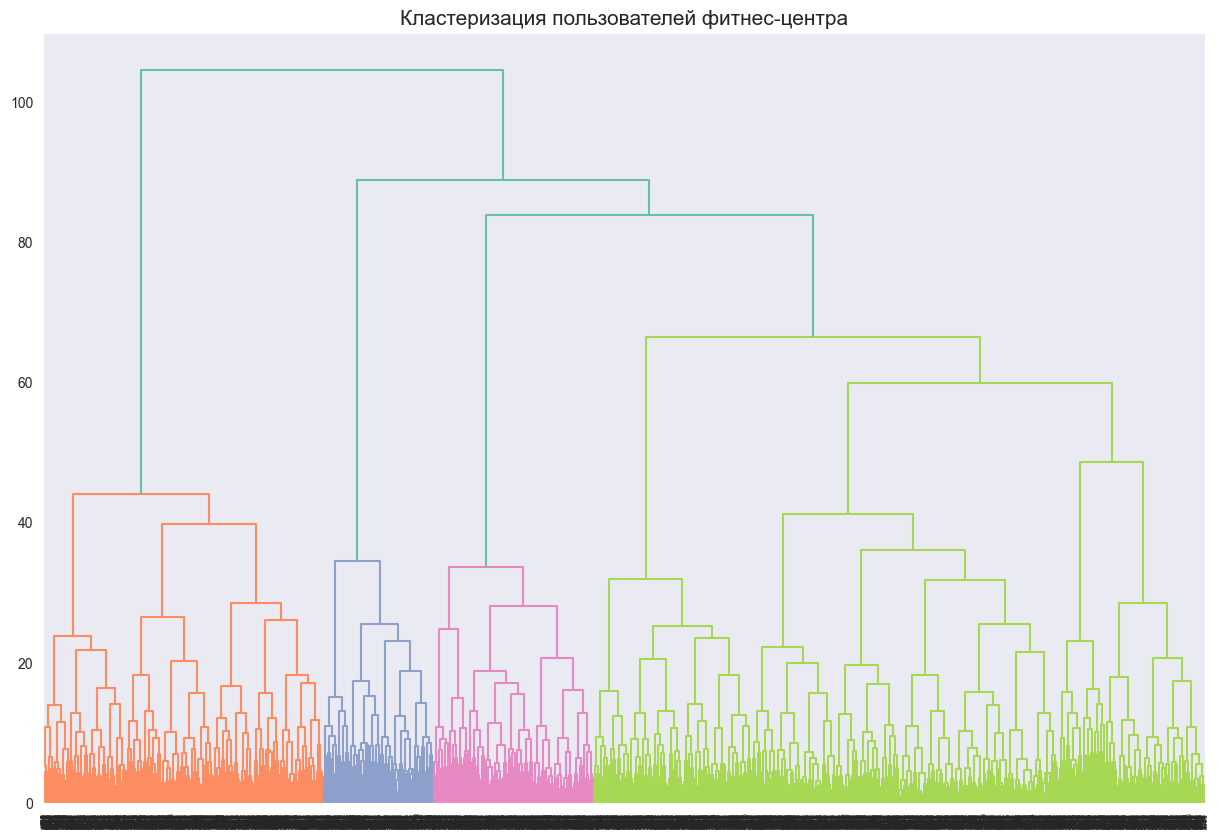

In [62]:
# построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков

X_st = scaler.fit_transform(X)
linked = linkage(X_st, method='ward')

# нарисуем дендрограмму

plt.figure(figsize = (15, 10))
dendrogram(linked, orientation='top')
plt.title('Кластеризация пользователей фитнес-центра', fontsize=15)
plt.show()

#### Предварительный вывод:
- По дендрограмме можно выделить 4 кластера клиентов

### Обучение модели кластеризации на основании алгоритма K-Means и построение прогноза по кластерам клиентов

Несмотря на то, что мы выделили 4 кластера клиентов по дендрограмме, возмем число=5, как указано в ТЗ

In [66]:
# обучение модели с помощью KMeans с числом кластеров 5

km = KMeans(n_clusters = 5, random_state = 0)

# спрогнозируем кластеры клиентов

labels = km.fit_predict(X_st)

# сохраним метки кластера в отдельном столбце df

df['cluster_km'] = labels

# для удобства заменим метки от 0 до 4 метками от 1 до 5

df['cluster_km'] = df['cluster_km'].replace(sorted(df['cluster_km'].unique()), list(range(1, 6)))

In [67]:
# посмотрим на размеры кластеров

clients_number = df['cluster_km'].value_counts()
clients_number

4    1262
1    1010
5     838
3     505
2     385
Name: cluster_km, dtype: int64

#### Предварительный вывод:
- Прогноз построен по 5 кластерам клиентов
- Самые многочисленные кластеры: 4-ый - 1262 и 1-ый - 1010 клиентов соответственно

### Анализ средних значений признаков и долей оттока для кластеров

In [70]:
# сгруппируем df по кластерам с расчетом средних значений признаков и переменной

clusters_means = df.groupby('cluster_km').mean().T

# добавим столбец со средним значением по всем кластерам 

clusters_means['mean'] = df.loc[:, 'gender': 'churn'].mean()

print('Cредние значения признаков для кластеров')
display(clusters_means)

# создадим отдельный датафрейм с информацией о размерах кластеров и оттоке клиентов

clusters_size = (pd.DataFrame(
    {'clients_number': df['cluster_km']
    .value_counts()})
    .reset_index(inplace=False)
    .rename(columns={'index': 'cluster'})
    .sort_values(by='cluster').set_index('cluster')
)

clusters_size['cluster_share'] = clusters_size['clients_number'] / clusters_size['clients_number'].sum()
clusters_size['churn'] = clusters_means.loc['churn']

print()
print('Размеры кластеров')
clusters_size = clusters_size.style.format({'cluster_share': '{:.0%}', 'churn': '{:.0%}'})
display(clusters_size)

# выведем топ-5 признаков по весам, присвоенным в оптимальной функции логистической регрессии

print()
print('Топ-5 признаков по весам, присвоенным в оптимальной функции логистической регрессии')
display(features.head())

Cредние значения признаков для кластеров


cluster_km,1,2,3,4,5,mean
gender,0.50,0.52,0.50,0.49,0.56,0.51
near_location,0.96,0.86,0.00,1.00,0.98,0.85
partner,0.78,0.47,0.46,0.35,0.36,0.49
promo_friends,0.57,0.31,0.08,0.24,0.23,0.31
phone,1.00,0.00,1.00,1.00,1.00,0.90
group_visits,0.54,0.43,0.22,0.34,0.47,0.41
contract_period,10.89,4.79,2.35,1.95,2.67,4.68
age,29.98,29.30,28.48,28.17,30.13,29.18
avg_add_charges_tot,160.76,143.96,135.46,131.62,161.66,146.94
month_to_end_contract,9.95,4.48,2.20,1.86,2.46,4.32



Размеры кластеров


,clients_number,cluster_share,churn
cluster,,,
1,1010,25%,3%
2,385,10%,27%
3,505,13%,44%
4,1262,32%,51%
5,838,21%,7%



Топ-5 признаков по весам, присвоенным в оптимальной функции логистической регрессии


,feature,coeff
0,avg_freq_cur_month,4.43
1,lifetime,3.72
2,avg_freq_tot,3.29
3,age,1.07
4,contract_period,0.70


#### Основные характеристики кластеров в разрезе средних значений признаков

**1 кластер:**
- второй по размеру - 25% клиентов
- ***самый низкий отток - всего 3%***
- ***96% клиентов живут близко от фитнес-центра***
- самые высокие показатели по привлечению по промо-акциям (78% из компаний-партнеров, 57% по акции "приведи друга")
- самый высокий показатель посещений групповых занятий - 54%
- одни из самых возрастных клиентов - почти 30 лет
- ***самая большая длительность текущего абонемента - почти 11 месяцев***
- самый большой срок до окончания абонемента - почти 10 месяцев
- lifetime - почти самая высокая - 4,7 мес.
- ***посещаемость - выше среднего***
- ***самый надежный и перспективный сегмент с точки зрения удержания клиентов***

**2 кластер:**

- ***самый маленький по размеру - всего 10% клиентов***
- отток клиентов на уровне среднего всем кластерам - 27%
- ***по всем признакам очень близок к средним значениям***
- ничем не примечателен, кроме того, что никто из клиентов не оставил свой номер телефона

**3 кластер:**

- небольшой кластер - 13% клиентов
- ***большой отток - 44%***
- ***все клиенты живут далеко от фитнес-центра***
- почти самый короткий срок текущего абонемента - 2,4 мес.
- ***короткий lifetime*** - 2,8 мес. (против средней по всем кластерам - 3,7)
- ***посещаемость ниже среднего***

**4 кластер:**
- ***самый большой кластер - 32% клиентов***
- ***самый большой отток - 51%***
- все клиенты живут рядом с фитнес-центром (но вес этого фактора не высок, и это не становится преимуществом)
- ***самая маленькая длительность текущего абонемента*** - меньше 2-х мес.
- ***самые молодые клиенты - порядка 28 лет***
- самые низкие допрасходы
- ***самый низкий lifetime - 2,4 мес.***
- ***самая низкая посещаемость*** - порядка 1 раза в неделю
- ***худший сегмент по топ-5 признаков, определяющих модель прогнозирования, и соответственно с точки зрения удержания клиентов***

**5 кластер:**
- средний по размеру сегмент - 21% клиентов
- ***низкий отток - 7%***
- ***почти все клиенты (98%) живут рядом с фитнес-центром***
- почти половина клиентов посещает групповые занятия
- ***самый возрастной сегмент - 30 лет***
- ***самый большой lifetime - почти 5 месяцев***
- небольшой срок текущего абонемента - менее 3 мес.
- самые большие расходы на доп услуги
- ***самая высокая посещаемость - почти 3 раза в неделю***
-***второй по надежности и перспективности кластер после 1-го кластера с точки зрения удержания клиентов*** 

#### Предварительный вывод:
***1) Самые надежные кластеры - 1-ый и 5-ый***:
 - отток 3% и 7% соответственно
 - самые длинные показатели lifetime: 4,7 и 4,9 мес. соответственно
 - почти все клиенты живут рядом с фитнес-центром: 96% и 98% соответственно
 - самые возрастные клиенты: порядка 30 лет
 - посещаемость выше среднего: порядка 2 и 3 раз в неделю соответственно
 - ***1-ый кластер превосходит 5-ый по перспективности***, поскольку имеет меньший отток и самую большую длительность текущего абонемента - почти 11 месяцев
 
***2) Самые ненадежные кластеры - 3-ий и 4-ый***:
- отток 44% и 51% соответственно
- различаются по удаленности проживания от фитнес-центра: все клиенты 3-го кластера живут далеко, все клиенты 4-го - близко (этот признак мало влияет на прогноз, вес в модели оптимального логистической регрессии - всего 0,08)
- самые короткие по сроку текущие абонементы: порядка 2,4 и 2 мес. соответственно
- самые низкие показатели lifetime 2,8 и 2,4 мес. соответственно
- плохая посещаемость
- ***4-ый кластер наименее перспективный сегмент***, поскольку он худший по топ-5 признаков, определяющих модель прогнозирования, и соответственно с точки зрения удержания клиентов 

### Анализ распределения признаков для кластеров на графиках

In [79]:
# создадим список дискретных признаков

discrete_list = list(category_columns)
discrete_list.insert(6, 'contract_period')
print('Дискретные признаки: ', discrete_list)

# создадим список непрерывных признаков

continuous_list = list(quantitative_columns[1:])
print('Непрерывные признаки: ', continuous_list)

Дискретные признаки:  ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'contract_period']
Непрерывные признаки:  ['age', 'avg_add_charges_tot', 'month_to_end_contract', 'lifetime', 'avg_freq_tot', 'avg_freq_cur_month']


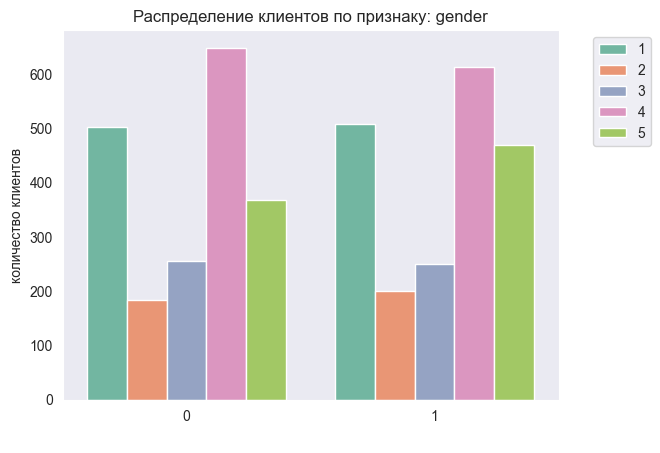

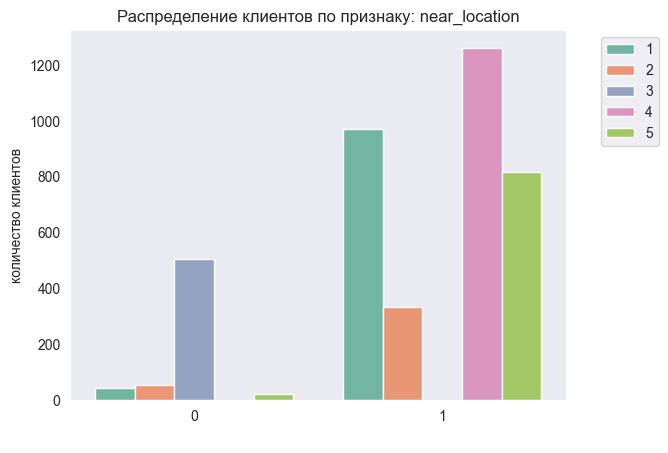

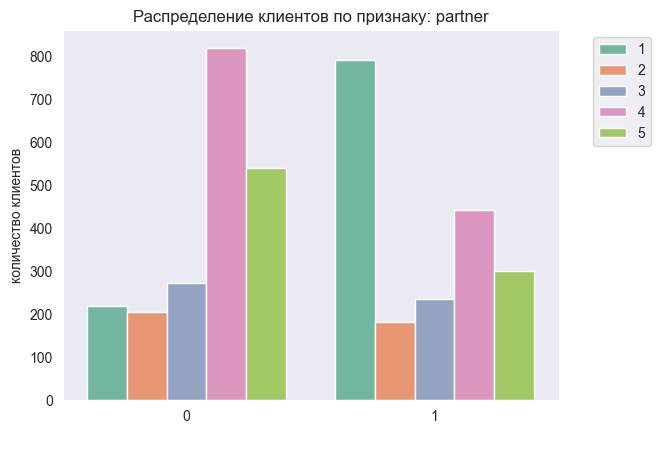

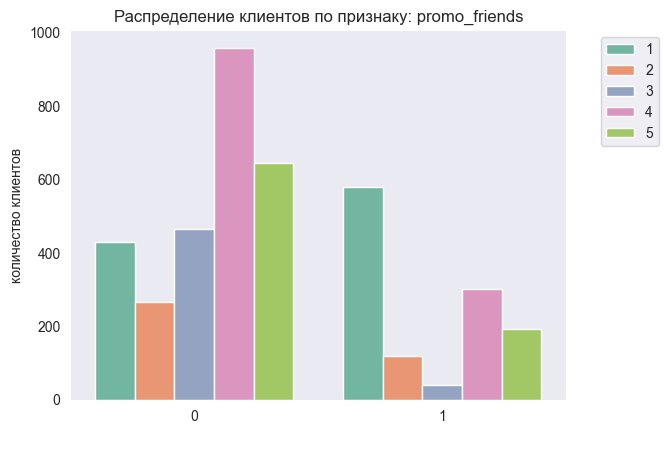

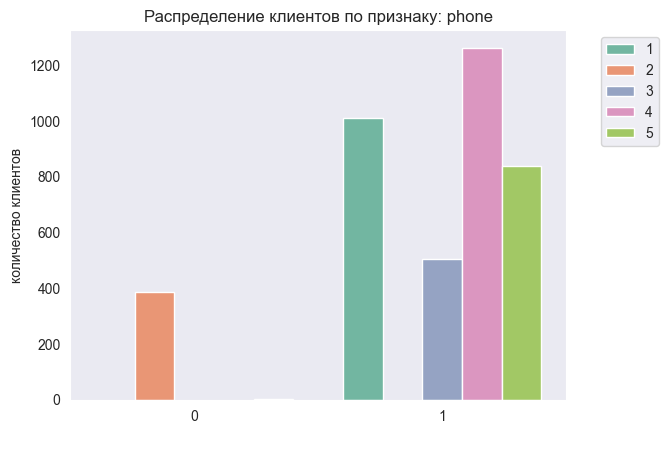

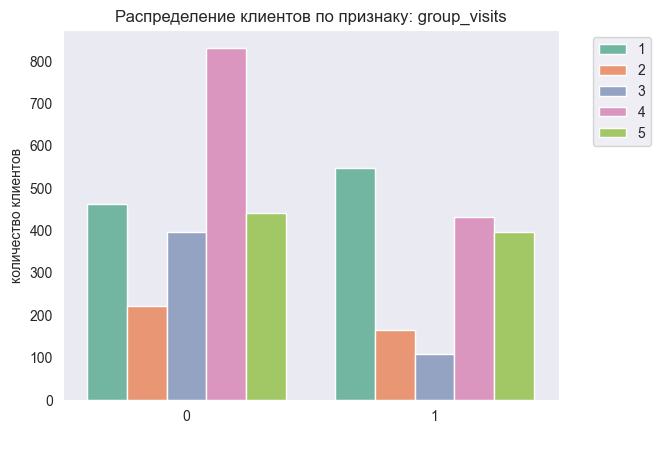

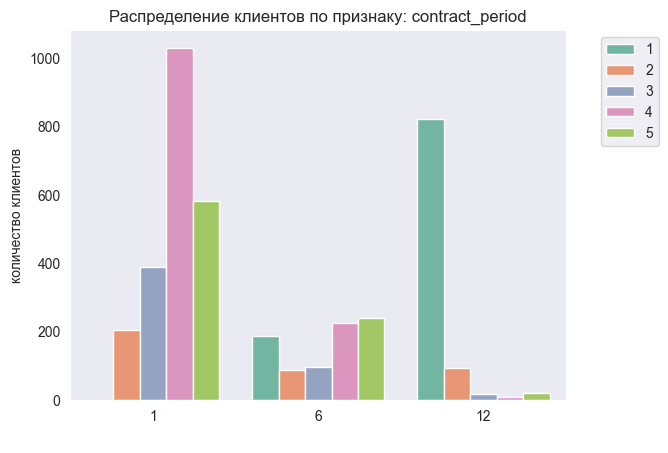

In [80]:
# построим графики countplot для дискретных признаков в разрезе кластеров

for col in discrete_list:
    sns.countplot(data=df, x=col, hue='cluster_km')
    plt.title('Распределение клиентов по признаку: '+ col)
    plt.xlabel(' ')
    plt.ylabel('количество клиентов')
    plt.legend()
    plt.legend(bbox_to_anchor=(1.2, 1))
    plt.show()

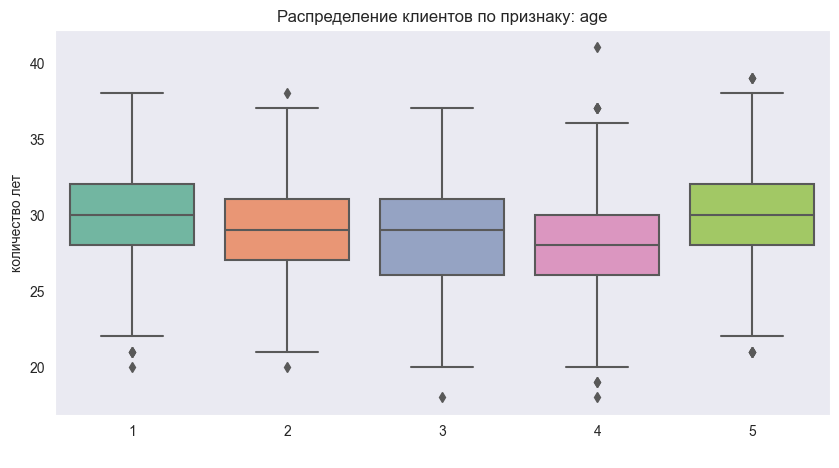

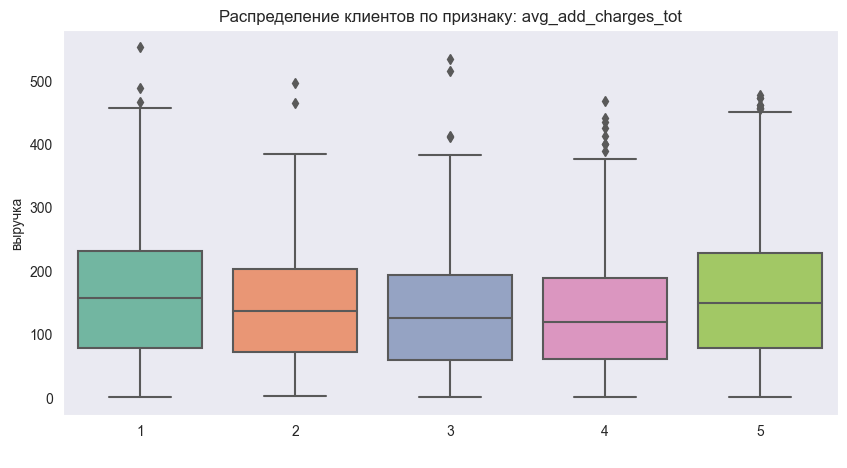

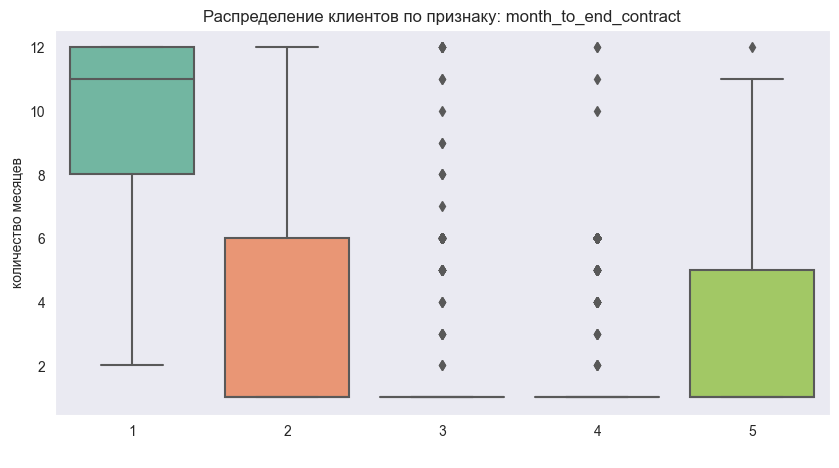

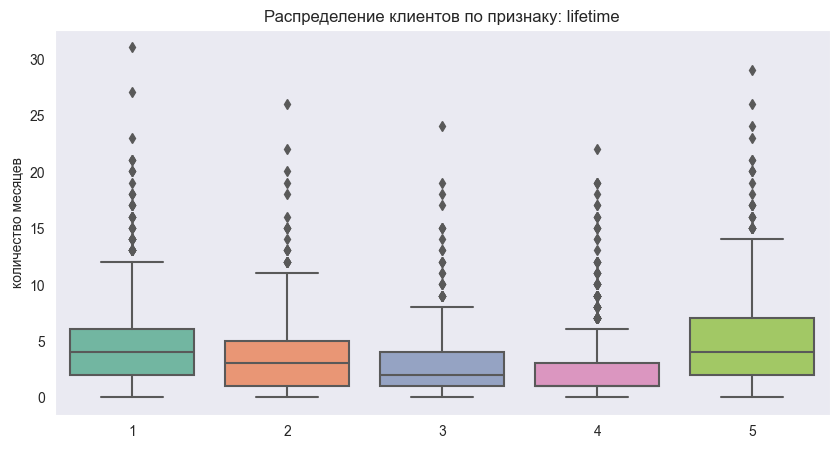

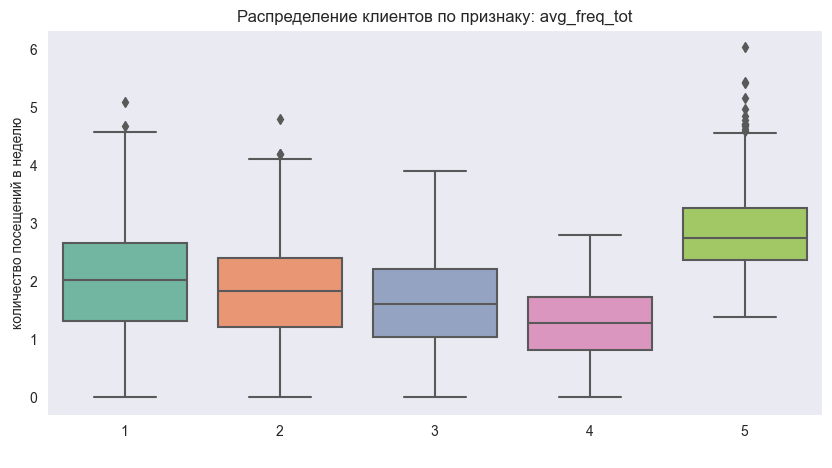

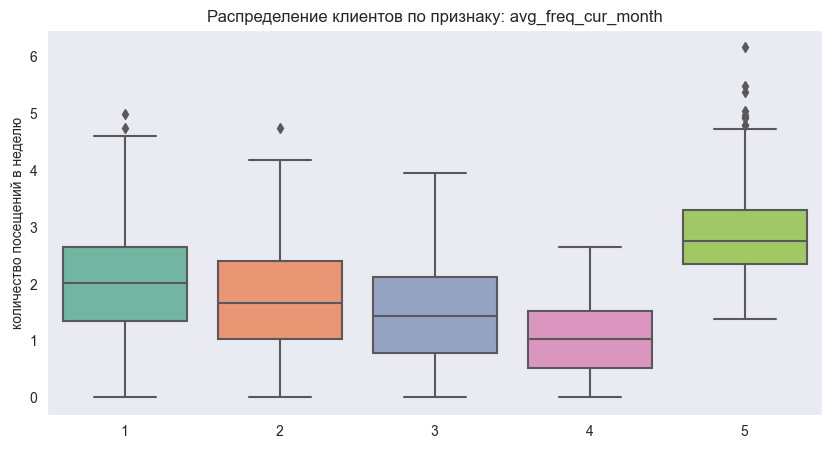

In [81]:
# построим диаграммы размаха для непрерывных признаков в разрезе кластеров

for col in continuous_list:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='cluster_km', y=col, data=df)
    plt.title('Распределение клиентов по признаку: ' + col)
    plt.ylabel(xlabel_name(col))
    plt.xlabel(' ')
    plt.show()

#### Предварительный вывод:
***Графики визуально подтверждают выводы, сделанные в п. 4.3 по оценке средних значений признаков:***
- по дискретным признакам: например, разделение кластеров по удаленности от фитнес-центра (4-ый кластер: 100% клиентов рядом, 3-ий ластер: 100% клиентов далеко), по длительности абонементов (4-ый кластер - преимущественно срок 6, 12 месяцев, по остальным кластерам - 1, 6 месяцев) и пр.
- по непрерывным признакам: например, разделение кластеров по посещаемости (лидерство 5-го сегмента), по lifetime (лучшие показатели у 1-го и 5-го сегмента) и пр.

### Вывод:
1) По дендрограмме можно выделить 4 кластера клиентов

2) Прогноз по кластерам построен по 5 кластерам клиентов, согласно ТЗ

3) Характеристика кластеров:

***Самые надежные кластеры - 1-ый и 5-ый***:
 - отток 3% и 7% соответственно
 - самые длинные показатели lifetime: 4,7 и 4,9 мес. соответственно
 - почти все клиенты живут рядом с фитнес-центром: 96% и 98% соответственно
 - самые возрастные клиенты: порядка 30 лет
 - посещаемость выше среднего: порядка 2 и 3 раз в неделю соответственно
 - ***1-ый кластер превосходит 5-ый по перспективности***, поскольку имеет меньший отток и самую большую длительность текущего абонемента - почти 11 месяцев
 
***Самые ненадежные кластеры - 3-ий и 4-ый***:
- отток 44% и 51% соответственно
- различаются по удаленности проживания от фитнес-центра: все клиенты 3-го кластера живут далеко, все клиенты 4-го - близко (этот признак мало влияет на прогноз, вес в модели оптимального логистической регрессии - всего 0,08)
- самые короткие по сроку текущие абонементы: порядка 2,4 и 2 мес. соответственно
- самые низкие показатели lifetime 2,8 и 2,4 мес. соответственно
- плохая посещаемость
- ***4-ый кластер наименее перспективный сегмент***, поскольку он худший по топ-5 признаков, определяющих модель прогнозирования, и соответственно с точки зрения удержания клиентов 

## Общий вывод и рекомендации по работе с клиентами сети фитнес-центров:


**1. Исследовательский анализ данных**

1) ***Усредненный клиент фитнес-центра имеет следующие характеристики:***
- пол: либо мужчина, либо женщина в соотношении примерно 50%/50%
- средний возраст: ***29 лет***
- адрес: ***в 85% случаев живет рядом***
- телефон: в 90% случаев оставляет свой номер
- промо-акции: в 40% и 30% случаев приходит через компании-партнеры и по акции "приведи друга" соответственно
- ***средний срок абонемента: почти 5 месяцев***
- ***средний lifetime - менее 4 месяцев***
- средний срок до окончания текущего абонемента - более 4 месяцев
- ***средняя посещаемость клуба - около 2-х раз в неделю***
- груповые занятия: посещает в среднем в 40% случаев
- средний отток: ***уходит из клуба насовсем в 27% случаев***

2) ***Клиенты, ушедшие из фитнес-центра, по сравнению с оставшимися характеризуются следующим образом:***
- живущих не в районе нахождения фитнес-центра - на 10% больше, чем среди оставшихся
- реже приходят по акции «приведи друга» (в 2 раза реже) или из компании-партнёра клуба (на 17% реже)
- ***в среднем на 3 года моложе*** (27 лет против 30 лет среди оставшихся)
- ***чаще выбирают более короткие абонементы***: около 2 месяцев против 6 месяцев у оставшихся
- ***реже посещают фитнес-клуб*** (1 и 1,5 раза в неделю за последний месяц и за весь срок абонемента соответственно против 2 раз по обеим периодам у оставшихся)
- почти на 20% реже посещают групповые занятия
- уходят примерно через месяц после начала посещения фитнес-центра (у оставшихся клиентов lifetime составляет на этот момент примерно 5 месяцев)
- соотвественно, меньше тратят денег на допуслуги в фитнес-центре за весь период: примерно на 30% меньше оставшихся

3) ***Корреляция между оттоком клиентов и их различными характеристиками не высокая***: лишь по некоторым признакам есть связь на уровне 0,4


**2. Построение модели прогнозирования оттока клиентов**

1) При построении моделей прогнозирования оттока клиентов:
 - обучающая и валидационная выборка разбиты в соотношении: 80 к 20
 - признаки переменной оттока стандартизированы
 - попарные мультиколлинеарные признаки не удалены из датасэта, поскольку логистическая регрессия уже регуляризирована по умолчанию и дает результат лучше, чем с их удалением
 
2) ***Логистическая регрессия дает незначительно, но все же лучший результат*** при прогнозировании оттока клиентов по сравнению со случайным лесом:
- по доли правильных ответов (accuracy) и точности (precision) результаты совпадают по обеим алгоритмам: 0,92 и 0,85 соответственно
- ***по полноте (recall) и агрегирующей метрике F1 результаты на 0,2 и 0,1 лучше:*** 0,83 и 0,84 против 0,81 и 0,83 соответственно

3) С точки зрения весов, ***основными признаками, определяющими модель*** прогнозирования оттока клиентов по алгоритму логистической регрессии, являются:
  - средняя посещаемость за текущий месяц и за весь период
  - срок посещения фитнес-центра (lifetime)
  - возраст клиента
  - срок абонемента


**3. Кластеризация клиентов**

**1 кластер:**
- второй по размеру - 25% клиентов
- ***самый низкий отток - всего 3%***
- ***96% клиентов живут близко от фитнес-центра***
- самые высокие показатели по привлечению по промо-акциям (78% из компаний-партнеров, 57% по акции "приведи друга")
- самый высокий показатель посещений групповых занятий - 54%
- одни из самых возрастных клиентов - почти 30 лет
- ***самая большая длительность текущего абонемента - почти 11 месяцев***
- самый большой срок до окончания абонемента - почти 10 месяцев
- lifetime - почти самая высокая - 4,7 мес.
- ***посещаемость - выше среднего***
- ***самый надежный и перспективный сегмент с точки зрения удержания клиентов***

**2 кластер:**

- ***самый маленький по размеру - всего 10% клиентов***
- отток клиентов на уровне среднего всем кластерам - 27%
- ***по всем признакам очень близок к средним значениям***
- ничем не примечателен, кроме того, что никто из клиентов не оставил свой номер телефона

**3 кластер:**

- небольшой кластер - 13% клиентов
- ***большой отток - 44%***
- ***все клиенты живут далеко от фитнес-центра***
- почти самый короткий срок текущего абонемента - 2,4 мес.
- ***короткий lifetime*** - 2,8 мес. (против средней по всем кластерам - 3,7)
- ***посещаемость ниже среднего***

**4 кластер:**
- ***самый большой кластер - 32% клиентов***
- ***самый большой отток - 51%***
- все клиенты живут рядом с фитнес-центром (но вес этого фактора не высок, и это не становится преимуществом)
- ***самая маленькая длительность текущего абонемента*** - меньше 2-х мес.
- ***самые молодые клиенты - порядка 28 лет***
- самые низкие допрасходы
- ***самый низкий lifetime - 2,4 мес.***
- ***самая низкая посещаемость*** - порядка 1 раза в неделю
- ***худший сегмент по топ-5 признаков, определяющих модель прогнозирования, и соответственно с точки зрения удержания клиентов***

**5 кластер:**
- средний по размеру сегмент - 21% клиентов
- ***низкий отток - 7%***
- ***почти все клиенты (98%) живут рядом с фитнес-центром***
- почти половина клиентов посещает групповые занятия
- ***самый возрастной сегмент - 30 лет***
- ***самый большой lifetime - почти 5 месяцев***
- небольшой срок текущего абонемента - менее 3 мес.
- самые большие расходы на доп услуги
- ***самая высокая посещаемость - почти 3 раза в неделю***
- ***второй по надежности и перспективности кластер после 1-го кластера с точки зрения удержания клиентов*** 


**4. Рекомендации по работе с клиентами**

1) Поскольку срок текущего абонемента существенно влияет на отток, рекомендуется ***улучшить ценовую политику в разрезе сроков абонементов в пользу более длинных абонементов*** (промо-акции, скидки и пр. на абонементы 6-12 месяцев)

2) Возрастные клиенты более лояльные, поэтому, возможно, стоит предусмотреть ***промо-акции для более молодых клиентов*** (например, скидки для студенов в счастливые часы и пр.) 

3) Устойчивое снижение частоты посещений может свидетельствовать о возможном уходе клиента в ближайшем будущем. Поэтому ***в случае падения посещаемости можно предусмотреть индивидуальные скидки и бонусы для удержания таких клиентов***

4) ***Компенсировать потери от различных скидок и промо-акций возможно за счет допуслуг***, суммарная выручка от которых растет с увеличением показателя lifetime